(tf-gpu) environment on anaconda

___
## JOSÉ LUIS PADILLA VALENZUELA
#### MODULO 4 La ciencia de datos. Técnicas de análisis, minería y visualización
#### EVALUACIÓN FINAL
___
### CONTEXTO

Cada día es más frecuente la introducción de la ciencia de datos en el ámbito del derecho y la justicia. Un ejemplo bien conocido de ello es el sistema COMPAS (Correctional offender management profiling for alternative sanctions) que se usa en varios estados de los Estados Unidos para hacer una evaluación del riesgo de reincidencia de las personas detenidas.

En este caso, proporciona un conjunto de datos en bruto con información de las evaluaciones (fichero compas-scores.csv) y la historia legal de unos 11.000 casos en los años 2013 y 2014 (se trata de uno de los ficheros originales utilizados en un análisis independiente del sistema COMPAS llevado a cabo por ProPublica, disponible en internet).

Aunque el conjunto de datos contiene información adicional, para resolver las cuestiones planteadas en este caso son necesarios (aparte de algunos campos cuyo nombre es autoexplicativo) los siguientes campos:

   compas_screening_date”  = FECHA en la que se realizó la EVALUACION
   decile_score            = RIESGO DE REINCIDENCIA EN GENERAL de 1 a 10 (a mayor riesgo, mayor número).
    v_decile_score          = RIESGO DE REINCIDENCIA EN DELITOS VIOLENTOS (potencialmente distinto del anterior), de 1 a 10 (a mayor riesgo, mayor número).
    is_recid                = PERSONA REINCIDENTE.
    r_offense_date          = FECHA en la que se cometió el DELITO por el que se considera REINCIDENTE.
    is_violent_recid        = REINCIDENTE EN UN DELITO CON VIOLENCIA.
    vr_offense_date         = FECHA DEL DELITO VIOLENTO.

### Se pide:

1- Cargar los datos y realizar un análisis exploratorio y una evaluación de la calidad de los datos necesarios para el resto del caso. Específicamente, evaluar la integridad, validez y actualidad de los datos y proponer estrategias de mitigación de los posibles problemas encontrados.

2- ¿Son los campos “is_recid” e “is_violent_recid” en este conjunto de datos adecuados para evaluar la precisión de las estimaciones de riesgo generadas por el sistema COMPAS? Si no es así, definir y calcular una feature que sí lo sea.

3- El umbral para establecer medidas preventivas de la reincidencia es de 7 en adelante. Dado este umbral, generar una tabla de contingencia, explicando qué caso se considera como “positivo” (y, por lo tanto, cuáles son los errores de tipo I y los errores de tipo II).

4- El sistema asigna, de media, evaluaciones de riesgo más altas a los hombres que a las mujeres, y a las personas de raza afroamericana que a las de raza caucásica. Sin embargo, también las tasas de reincidencia son más altas para esos colectivos, aunque no está claro que la asignación de riesgo sea “justa” o no. Mostrar estas diferencias mediante representaciones gráficas y utilizarlas para analizar si la asignación de evaluaciones es justa o no.

5- ¿Para qué tipo de riesgos, el de delitos generales o el de delitos violentos, tiene el sistema más capacidad predictiva?

In [1]:
# Tratamiento de datos
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype
from pandas.plotting import scatter_matrix
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

# pd.set_option('display.max_columns', 60) #Display 60 columns for better visualitation. 

# Graficos
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from plotnine import *

#from bokeh.io import output_notebook, show
#from bokeh.plotting import figure

# Configuracion warnings
import warnings
warnings.simplefilter("ignore")

#Preprocesado y analisis
import statsmodels.api as sm
from scipy import stats
from scipy.stats import pearsonr

#### 1- Cargar los datos y realizar un análisis exploratorio y una evaluación de la calidad de los datos necesarios para el resto del caso. 
Específicamente, evaluar la integridad, validez y actualidad de los datos y proponer estrategias de mitigación de los posibles problemas encontrados.

* validez (conformidad con los formatos y estándares)
* integridad (ausencia de “huecos” en los datos)
* actualidad (datos suficientemente recientes).

In [2]:
# Cargamos los datos desde el archivo CSV
compas = pd.read_csv('C:\\Users\\jlpad\Desktop\\BBDD\\compas-scores.csv') 

In [3]:
# Comenzamos el analisis explotarotio del dataframe.
compas.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,vr_offense_date,vr_charge_desc,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,type_of_assessment,decile_score.1,score_text,screening_date
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,NaN,NaN,Risk of Violence,1,Low,2013-08-14,Risk of Recidivism,1,Low,2013-08-14
1,2,michael ryan,michael,ryan,2014-12-31,Male,1985-02-06,31,25 - 45,Caucasian,...,NaN,NaN,Risk of Violence,2,Low,2014-12-31,Risk of Recidivism,5,Medium,2014-12-31
2,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,2013-07-05,Felony Battery (Dom Strang),Risk of Violence,1,Low,2013-01-27,Risk of Recidivism,3,Low,2013-01-27
3,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,NaN,NaN,Risk of Violence,3,Low,2013-04-14,Risk of Recidivism,4,Low,2013-04-14
4,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,NaN,NaN,Risk of Violence,6,Medium,2013-01-13,Risk of Recidivism,8,High,2013-01-13


In [4]:
compas.columns

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'num_r_cases',
       'r_case_number', 'r_charge_degree', 'r_days_from_arrest',
       'r_offense_date', 'r_charge_desc', 'r_jail_in', 'r_jail_out',
       'is_violent_recid', 'num_vr_cases', 'vr_case_number',
       'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'type_of_assessment', 'decile_score.1',
       'score_text', 'screening_date'],
      dtype='object')

In [5]:
compas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11757 entries, 0 to 11756
Data columns (total 47 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       11757 non-null  int64  
 1   name                     11757 non-null  object 
 2   first                    11757 non-null  object 
 3   last                     11757 non-null  object 
 4   compas_screening_date    11757 non-null  object 
 5   sex                      11757 non-null  object 
 6   dob                      11757 non-null  object 
 7   age                      11757 non-null  int64  
 8   age_cat                  11757 non-null  object 
 9   race                     11757 non-null  object 
 10  juv_fel_count            11757 non-null  int64  
 11  decile_score             11757 non-null  int64  
 12  juv_misd_count           11757 non-null  int64  
 13  juv_other_count          11757 non-null  int64  
 14  priors_count          

In [6]:
# Creamos una copia del dataframe inicial tomando en cuenta solo 17 de las 47 columnas que consideramos importantes para nuestro caso.
df = compas[['id','name', 'sex', 'age', 'age_cat', 'is_recid', 'is_violent_recid','decile_score', 'v_decile_score', 'vr_offense_date', 
             'r_offense_date', 'race', 'score_text', 'v_score_text', 'compas_screening_date', 'c_charge_degree', 'priors_count']].copy()

In [7]:
# De las 17 columnas todas excepto 4 (r_offense_date, , vr_offense_date, v_score_text y score_text) cuentan con 11.757 datos.  
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11757 entries, 0 to 11756
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     11757 non-null  int64 
 1   name                   11757 non-null  object
 2   sex                    11757 non-null  object
 3   age                    11757 non-null  int64 
 4   age_cat                11757 non-null  object
 5   is_recid               11757 non-null  int64 
 6   is_violent_recid       11757 non-null  int64 
 7   decile_score           11757 non-null  int64 
 8   v_decile_score         11757 non-null  int64 
 9   vr_offense_date        882 non-null    object
 10  r_offense_date         3703 non-null   object
 11  race                   11757 non-null  object
 12  score_text             11742 non-null  object
 13  v_score_text           11752 non-null  object
 14  compas_screening_date  11757 non-null  object
 15  c_charge_degree    

In [8]:
# Definimos una función para ver los nulos y porcentaje de nulos del dataframe.
def show_nulls(df):
    total_nulos = df.isnull().sum()
    perc_nulos = total_nulos/len(df)*100
    return total_nulos, perc_nulos

In [9]:
# Se puede ver que los nulos se encuentran solamente en 4 de las 17 columnas:
    
#    vr_offense_date             "FECHA en la que se cometió el DELITO VIOLENTO que da lugar a la consideración de reincidente".
#    r_offense_date              "FECHA en la que se cometió el DELITO por el que se considera reincidente a la persona",
#    score_text                  "SCORE" 
#    v_score_text                "SCORE VIOLENTO"

print('Total nulos   ', show_nulls(df=df)[0])
print('Porcentaje de nulos    ', show_nulls(df=df)[1])

Total nulos    id                           0
name                         0
sex                          0
age                          0
age_cat                      0
is_recid                     0
is_violent_recid             0
decile_score                 0
v_decile_score               0
vr_offense_date          10875
r_offense_date            8054
race                         0
score_text                  15
v_score_text                 5
compas_screening_date        0
c_charge_degree              0
priors_count                 0
dtype: int64
Porcentaje de nulos     id                        0.000000
name                      0.000000
sex                       0.000000
age                       0.000000
age_cat                   0.000000
is_recid                  0.000000
is_violent_recid          0.000000
decile_score              0.000000
v_decile_score            0.000000
vr_offense_date          92.498086
r_offense_date           68.503870
race                      0.000000
s

Tomando en cuenta que tenemos 11.757 registros en total que existan datos nulos en tres columnas nos sugiere que la informacón NO ES INTEGRA.

    vr_offense_date         10.875 (92.49%)
    r_offense_date           8.054 (68.50%)   
    
Para las otras dos la cantidad de valores nulos no llegan ni al 1%; por tanto no son significativas.

    score_text                  15 (0.13%)
    v_score_text                 5 (0.04%)

Vamos a revisar cada columna individualmente para asegurarnos si la infomacion es VALIDA, INTEGRA y SIN VALORES NULOS.

In [10]:
# Definimos otra función para analizar la integridad, validez y actualidad de los datos de cada una de las columnas.
def desc_column(df, col):
    print(f'Columna: {col} - Tipo de datos: {df[col].dtype}')
    print(f'Número de valores nulos: {df[col].isnull().sum()} - Número de valores distintos: {df[col].nunique()}')
    print('Valores más frecuentes:')
    for i, v in df[col].value_counts().iloc[:10].items():
        print(i, '\t', v)

In [11]:
# Columna valida e integra sin valores nulos.
desc_column(df, 'id')

Columna: id - Tipo de datos: int64
Número de valores nulos: 0 - Número de valores distintos: 11757
Valores más frecuentes:
2049 	 1
6790 	 1
10888 	 1
8841 	 1
2700 	 1
653 	 1
6798 	 1
4751 	 1
10896 	 1
8849 	 1


In [12]:
# Se puede ver que algunos nombres se repiten de 3 a 4 veces estos podrían ser duplicados o simplemente homónimos. 
# Columna valida e integra sin valores nulos.
desc_column(df, 'name')

Columna: name - Tipo de datos: object
Número de valores nulos: 0 - Número de valores distintos: 11584
Valores más frecuentes:
robert taylor 	 4
michael cunningham 	 4
carlos vasquez 	 4
john brown 	 4
gregory williams 	 3
anthony jackson 	 3
steven wilson 	 3
james brown 	 3
richard jones 	 3
travis wilson 	 3


In [13]:
# Columna valida e integra sin valores nulos.
desc_column(df, 'sex')

Columna: sex - Tipo de datos: object
Número de valores nulos: 0 - Número de valores distintos: 2
Valores más frecuentes:
Male 	 9336
Female 	 2421


In [14]:
# Columna valida e integra sin valores nulos. Van desde los 18 a los 96 años.
desc_column(df, 'age')
print(df.age.min())
print(df.age.max())

Columna: age - Tipo de datos: int64
Número de valores nulos: 0 - Número de valores distintos: 66
Valores más frecuentes:
26 	 540
24 	 539
25 	 521
23 	 507
27 	 506
22 	 503
21 	 500
29 	 456
30 	 441
28 	 430
18
96


In [15]:
# Columna valida e integra sin valores nulos.
desc_column(df, 'age_cat')

Columna: age_cat - Tipo de datos: object
Número de valores nulos: 0 - Número de valores distintos: 3
Valores más frecuentes:
25 - 45 	 6649
Greater than 45 	 2668
Less than 25 	 2440


In [16]:
# Columna valida e integra sin valores nulos.
desc_column(df, 'race')

Columna: race - Tipo de datos: object
Número de valores nulos: 0 - Número de valores distintos: 6
Valores más frecuentes:
African-American 	 5813
Caucasian 	 4085
Hispanic 	 1100
Other 	 661
Asian 	 58
Native American 	 40


In [17]:
# CARGO POR DELITO MAYOR O MENOR 
# Columna valida e integra sin valores nulos.
desc_column(df, 'c_charge_degree')

Columna: c_charge_degree - Tipo de datos: object
Número de valores nulos: 0 - Número de valores distintos: 3
Valores más frecuentes:
F 	 7232
M 	 3771
O 	 754


In [18]:
# NUMERO DE ARRESTOS PREVIOS
# Columna valida e integra sin valores nulos.
desc_column(df, 'priors_count')

Columna: priors_count - Tipo de datos: int64
Número de valores nulos: 0 - Número de valores distintos: 39
Valores más frecuentes:
0 	 4184
1 	 2199
2 	 1281
3 	 857
4 	 588
5 	 474
6 	 349
7 	 315
8 	 260
9 	 201


In [19]:
# Indica el RIESGO DE REINCIDENCIA en general (a mayor riesgo, mayor número).
# Columna valida e integra sin valores nulos.
desc_column(df, 'decile_score')

Columna: decile_score - Tipo de datos: int64
Número de valores nulos: 0 - Número de valores distintos: 11
Valores más frecuentes:
1 	 2577
2 	 1572
3 	 1259
4 	 1199
5 	 1034
6 	 993
7 	 900
9 	 802
8 	 796
10 	 610


In [20]:
# Indica si la persona ES REINCIDENTE, observamos 3.703 registros que si serian reincidentes. Encontramos 719 registros sin antecedentes.
# Columna valida e integra sin valores nulos.
desc_column(df, 'is_recid')

Columna: is_recid - Tipo de datos: int64
Número de valores nulos: 0 - Número de valores distintos: 3
Valores más frecuentes:
0 	 7335
1 	 3703
-1 	 719


In [21]:
# de 1 a 10, indica el RIESGO DE REINCIDENCIA EN DELITOS VIOLENTOS (a mayor riesgo, mayor número).
# Columna valida e integra sin valores nulos.
desc_column(df, 'v_decile_score')

Columna: v_decile_score - Tipo de datos: int64
Número de valores nulos: 0 - Número de valores distintos: 11
Valores más frecuentes:
1 	 3359
2 	 1789
3 	 1581
4 	 1239
5 	 1083
6 	 919
7 	 666
8 	 476
9 	 440
10 	 200


In [22]:
# Indica si la persona es REINCIDENTE EN UN DELITO CON VIOLENCIA, observamos 882 registros que si serían reincidentes.
# Columna valida e integra sin valores nulos.
desc_column(df, 'is_violent_recid')

Columna: is_violent_recid - Tipo de datos: int64
Número de valores nulos: 0 - Número de valores distintos: 2
Valores más frecuentes:
0 	 10875
1 	 882


In [23]:
# Columna valida e integra sin valores nulos.
desc_column(df, 'compas_screening_date')

Columna: compas_screening_date - Tipo de datos: object
Número de valores nulos: 0 - Número de valores distintos: 704
Valores más frecuentes:
2013-03-20 	 39
2013-04-20 	 38
2013-09-23 	 35
2013-02-20 	 34
2013-02-22 	 33
2013-09-26 	 33
2013-08-27 	 32
2014-11-12 	 32
2013-02-07 	 32
2013-10-07 	 31


In [24]:
# FECHA DEL DELITO por el que se considera reincidente a la persona.
# Columna valida, aparentemente NO integra con 8.054 (68.50%) valores nulos pero los 3.703 (31.50%) registros que si estan corresponderían a personas reincidentes que coincide con (is_recid).
desc_column(df, 'r_offense_date')

df['r_offense_date'].value_counts().sum()

Columna: r_offense_date - Tipo de datos: object
Número de valores nulos: 8054 - Número de valores distintos: 1090
Valores más frecuentes:
2014-12-08 	 12
2015-01-28 	 11
2015-02-10 	 11
2014-09-15 	 10
2014-06-07 	 10
2014-10-17 	 10
2015-03-11 	 10
2014-06-05 	 10
2014-04-03 	 10
2014-07-28 	 9


3703

In [25]:
# FECHA DEL DELITO VIOLENTO que da lugar a la consideración de reincidente.
# Columna valida, aparentemente NO integra con 10.875 (92.5%) de valores nulos.  
desc_column(df, 'vr_offense_date')

Columna: vr_offense_date - Tipo de datos: object
Número de valores nulos: 10875 - Número de valores distintos: 599
Valores más frecuentes:
2015-08-15 	 6
2015-09-04 	 5
2015-10-01 	 4
2015-06-27 	 4
2015-03-29 	 4
2014-02-18 	 4
2014-07-28 	 4
2015-04-27 	 4
2015-10-14 	 4
2014-12-26 	 4


In [26]:
# 882 registros que coincide con un REINCIDENTE EN UN DELITO CON VIOLENCIA (is_violent_recid). 
df['vr_offense_date'].value_counts().sum()

882

In [27]:
# SCORE DELITO NO VIOLENTO
# Columna valida e integra con solo 15 valores nulos, el 0.13%.
desc_column(df,'score_text')

Columna: score_text - Tipo de datos: object
Número de valores nulos: 15 - Número de valores distintos: 3
Valores más frecuentes:
Low 	 6607
Medium 	 2927
High 	 2208


In [28]:
# SCORE DELITO VIOLENTO 
# Columna valida e integra con solo 5 valores nulos, el 0.04%.
desc_column(df, 'v_score_text')

Columna: v_score_text - Tipo de datos: object
Número de valores nulos: 5 - Número de valores distintos: 3
Valores más frecuentes:
Low 	 7968
Medium 	 2668
High 	 1116


2- ¿Son los campos “is_recid” e “is_violent_recid” en este conjunto de datos adecuados para evaluar la precisión de las estimaciones de riesgo generadas por el sistema COMPAS?
Si no es así, definir y calcular una feature que sí lo sea.

In [29]:
# Creamos una copia del dataframe inicial "df" para trabajar independientemente sin afectar al punto 1 con cada cambio que realicemos a partir de ahora.
df1 = compas[['id', 'name', 'sex', 'age', 'age_cat', 'race', 'c_charge_degree', 'priors_count', 'is_recid', 'is_violent_recid', 'decile_score', 
          'v_decile_score', 'score_text', 'v_score_text', 'r_offense_date', 'vr_offense_date', 'compas_screening_date']].copy()

In [30]:
# RIESGO DE REINCIDENCIA
df1['decile_score'].value_counts()

 1     2577
 2     1572
 3     1259
 4     1199
 5     1034
 6      993
 7      900
 9      802
 8      796
 10     610
-1       15
Name: decile_score, dtype: int64

In [31]:
# Eliminmos los 15 valores sin antecedentes.
df1 = df1.drop(df1[df1['decile_score']== -1].index)
df1['decile_score'].value_counts()

1     2577
2     1572
3     1259
4     1199
5     1034
6      993
7      900
9      802
8      796
10     610
Name: decile_score, dtype: int64

In [32]:
# REINCIDENTE 
df1['is_recid'].value_counts()

 0    7326
 1    3701
-1     715
Name: is_recid, dtype: int64

In [33]:
# Eliminmos los 715 valores sin antecedentes de reincidencia.
df1 = df1.drop(df1[df1['is_recid']== -1].index)
df1['is_recid'].value_counts()

0    7326
1    3701
Name: is_recid, dtype: int64

In [34]:
# La correlacion entre RIESGO DE REINCIDENCIA y REINCIDENTE es "0.28"
corr_mat1 = df1.corr()
corr_mat1.loc['is_recid', 'decile_score']

0.2818400252884746

In [35]:
# RIESGO DE REINCIDENCIA VIOLENTA
df1['v_decile_score'].value_counts()

1     3095
2     1689
3     1483
4     1180
5     1017
6      855
7      644
8      454
9      423
10     187
Name: v_decile_score, dtype: int64

In [36]:
# REINCIDENTE CON VIOLENCIA
df1['is_violent_recid'].value_counts()

0    10145
1      882
Name: is_violent_recid, dtype: int64

In [37]:
# La correlacion entre RIESGO DE REINCIDENCIA VIOLENTA (v_decile_score) Y REINCIDENTE CON VIOLENCIA (is_violent_recid) es "0.16"
corr_mat2 = df1.corr()
corr_mat2.loc['is_violent_recid', 'v_decile_score']

0.15752055968810763

Text(0.5, 1.0, 'Correlacion entre variables')

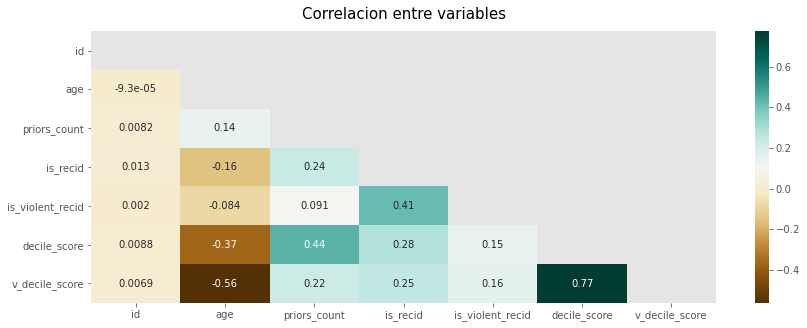

In [38]:
# Vamos a ver gráficamente la correlación entre variables con un gráfico de Seaborn Correlation Heatmap.
plt.figure(figsize=(14,5))
mask = np.triu(np.ones_like(df1.corr(), dtype=np.bool))
heatmap = sns.heatmap(df1.corr(), mask=mask, annot=True, cmap='BrBG')
heatmap.set_title('Correlacion entre variables', fontdict={'fontsize':15}, pad=12)

A la pregunta planteada de sí ¿son los campos “is_recid” e “is_violent_recid” adecuados para evaluar la precisión de las estimaciones de riesgo generadas por el sistema COMPAS?

Basandome en el análisis de correlaciones entre:

    decile_score e is_recid             = 0.28 
    v_decile_score e is_violent_recid   = 0.16

Puedemos indicar que estas dos variables no cuentan con una correlación alta ya que ambas están más proximas a cero por tanto no las considero adecuadas.

Siguiendo como ejemplo el trabajo de Propublica voy a analizar el modelo COMPAS tomando en cuenta las variables r_offense_date, vr_offense_date y compas_screening_date de los dos ultimos años.

In [39]:
# Creamos "df_date" 
df_date = df1.copy()

In [40]:
# Eliminamos los nulos de la variable r_offense_date para asi contar con los datos de todos los REINCIDENTES NO VIOLENTOS por fechas de reincidencia.
df_date.drop(df_date[df_date.r_offense_date.isnull()].index, inplace = True)

In [41]:
# Reenumeramsos las filas desde cero.
df_date.reset_index(inplace=True, drop=True)

In [42]:
# Remplazamos el index por los valores de la columna r_offense_date
df_date.index  = df_date['r_offense_date']
type(df_date.index[0])
df_date.drop('r_offense_date', axis=1, inplace=True)

In [43]:
#Eliminamos las fechas previas al 30/03/2014 para trabajar con los ultimos dos años. 
df_date = df_date.loc['2014-03-30':]

In [44]:
# Creamos un modelo para la Feature1
def model1(caso):
    if caso['is_violent_recid'] == 1 and caso['race'] == ('African-American') and caso['age_cat'] == ('25 - 45'):
        return 1
    else:
        return 0
    
feature1 = df_date.apply(lambda x: model1(x), axis = 1)

In [45]:
# Verificación de la efectividad del model1 que es bajo llega solo a "0.46" lo cual esta más cercano a cero que a uno, 
# podemos decir que el modelo no es correcto aunque el resultado es mejore que el anterior que tomaba en cuentan las otras variables:

#    decile_score e is_recid             = 0.28 
#    v_decile_score e is_violent_recid   = 0.16

roc_auc_score((df_date['v_score_text'] == 'Low'), feature1)

0.46524228174197507

3- El umbral para establecer medidas preventivas de la reincidencia es de 7 en adelante. Dado este umbral, generar una tabla de contingencia, 
   explicando qué caso se considera como “positivo” (y, por lo tanto, cuáles son los errores de tipo I y los errores de tipo II).

In [46]:
# Model2 para las predicciones de REINCIDENTE "is_recid"
def model2(caso):
    if caso['is_recid'] == 1 or caso['is_violent_recid'] == 1 and caso['age_cat'=='25 - 45'] and caso['sex'] == ('Male'):
        return 1
    else:
        return 0

feature2 = df1.apply(lambda x: model2(x), axis = 1).rename('Predicción')

In [47]:
# Feature2 nos da un valor más próximo a 1, "0.62" lo que nos dice que su predicción es medianemente correcta.
roc_auc_score((df1['decile_score'] >= 7), feature2)

0.6175484622683529

In [48]:
# Como se puede ver en la tabla de contigencia "tc2" según la predicción tenemos: 
    
    # ERRORES TIPO I / FALSOS POSITIVOS 
    # (esquina superior derecha - True/0)  1.458 casos 
    # NO POSIBLES REINCIDENTES cuando en verdad su decile_score es >= 7 

    # ERRORES TIPO II / FALSOS NEGATIVOS 
    # (esquina inferior izquierda - False/1) 2.198 casos 
    # POSIBLES REINCIDENTES cuando en verdad su decile_score es >=7    

tc2 = pd.crosstab(feature2, (df1['decile_score'] >= 7))
tc2

decile_score,False,True
Predicción,,
0,5868,1458
1,2198,1503


4- El sistema asigna, de media, evaluaciones de riesgo más altas a los hombres que a las mujeres, y a las personas de raza afroamericana que a las de raza caucásica. 
   
   Sin embargo, también las tasas de reincidencia son más altas para esos colectivos, aunque no está claro que la asignación de riesgo sea “justa” o no. 

   Mostrar estas diferencias mediante representaciones gráficas y utilizarlas para analizar si la asignación de evaluaciones es justa o no.

In [49]:
# Creamos una copia del dataframe inicial "df1" para trabajar independientemente sin afectar al resto de dataframes con los cambios que vayamos a realizar.
df2 = df1[['id', 'name', 'sex', 'age', 'age_cat', 'race', 'c_charge_degree', 'is_recid', 'is_violent_recid',
           'decile_score', 'v_decile_score', 'score_text', 'v_score_text', 'r_offense_date', 'vr_offense_date']].copy()

desc_column(df2, 'decile_score')
desc_column(df2, 'v_decile_score')

Columna: decile_score - Tipo de datos: int64
Número de valores nulos: 0 - Número de valores distintos: 10
Valores más frecuentes:
1 	 2368
2 	 1478
3 	 1167
4 	 1130
5 	 982
6 	 941
7 	 862
9 	 761
8 	 758
10 	 580
Columna: v_decile_score - Tipo de datos: int64
Número de valores nulos: 0 - Número de valores distintos: 10
Valores más frecuentes:
1 	 3095
2 	 1689
3 	 1483
4 	 1180
5 	 1017
6 	 855
7 	 644
8 	 454
9 	 423
10 	 187


4.1- Comenzaremos graficando decile_score y analizando uno a uno las variables ETNIA y GENERO para los tres grupos con más registros

Columna: race - Tipo de datos: object
Número de valores nulos: 0 - Número de valores distintos: 6
Valores más frecuentes:
African-American 	 5498
Caucasian 	 3811
Hispanic 	 1009
Other 	 620
Asian 	 53
Native American 	 36


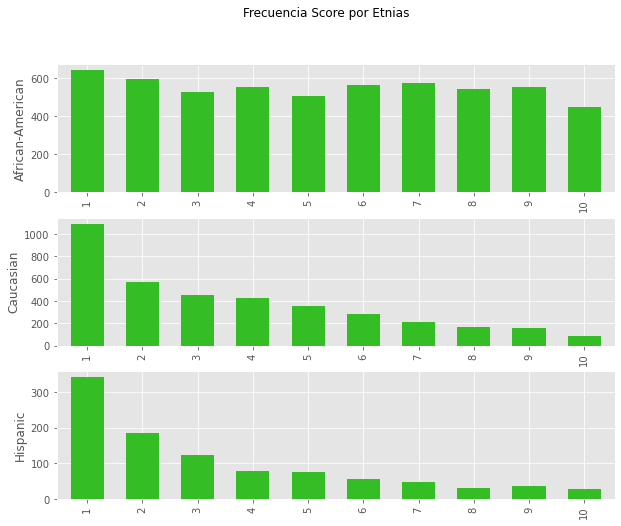

In [50]:
# ETNIA  DECILE SCORE
# Como se puede ver en el gráfico, la distribucion de las personas Afroamericanas es uniforme de 1 a 10, 
# para las demás etnias, en todos de los casos, los valores se concentran y son más altos en 1 y van bajando progresivamente hasta 10, lo cual nos
# indica que presentan menor tendencia a reincidir.

desc_column(df2, 'race')

df_race_ds = df2.groupby('race')
race_count_ds = df2.groupby('race')['name'].count()

fig, ax = plt.subplots(3, figsize=(10, 8))

for (i, race) in enumerate(['African-American', 'Caucasian', 'Hispanic']):
    ((df_race_ds.get_group(race).groupby('decile_score')['name'].count()).plot(kind='bar', ax=ax[i], color='#35bd26', width = 0.6))
      
    ax[i].set_ylabel(race)
    ax[i].set_xlabel('')

    
fig.suptitle("Frecuencia Score por Etnias")
plt.show()

Columna: sex - Tipo de datos: object
Número de valores nulos: 0 - Número de valores distintos: 2
Valores más frecuentes:
Male 	 8764
Female 	 2263


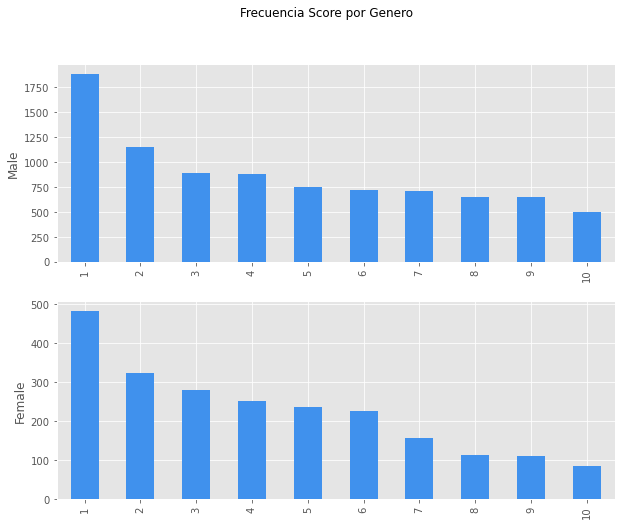

In [51]:
# GENERO  DECILE SCORE
# Este gráfico nos muestra una clara preponderancia en cuanto a la cantidad de HOMBRES respecto de MUJERES en todos los niveles con mas del triple, 
# estando ambos concentrados en los primeros 6 niveles y con una visible tendencia decreciente de menor a mayor posibilidad de reincidencia.

desc_column(df2, 'sex')

df_sex_ds = df2.groupby('sex')
sex_count_ds = df2.groupby('sex')['name'].count()

fig, ax = plt.subplots(2, figsize=(10, 8))

for (i, sex) in enumerate(['Male', 'Female']):
    ((df_sex_ds.get_group(sex).groupby('decile_score')['name'].count()).plot(kind='bar', ax=ax[i], color='#4091ed'))
    
    ax[i].set_ylabel(sex)
    ax[i].set_xlabel('')
   
fig.suptitle("Frecuencia Score por Genero")
plt.show()

Columna: race - Tipo de datos: object
Número de valores nulos: 0 - Número de valores distintos: 6
Valores más frecuentes:
African-American 	 5498
Caucasian 	 3811
Hispanic 	 1009
Other 	 620
Asian 	 53
Native American 	 36


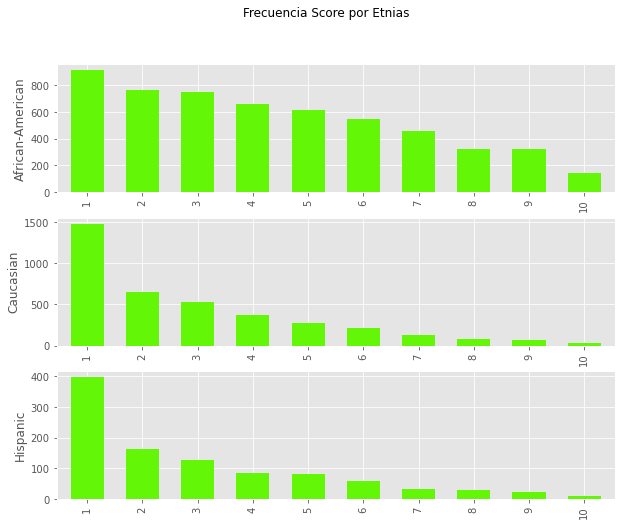

In [52]:
# ETNIA  VIOLENT DECILE SCORE
# Como se puede ver en el gráfico, la distribucion de las personas Afroamericanas con Riesgo de Reincidencia Violenta tiene un comportamiento decreciente concentradose el mayor numero de casos,
# en los niveles más bajos de riesgo 1. Esto muestra una diferencia notable en cuanto a los registros de este grupo en Riesgo de Reincidencia. DECILE SCORE.  
# Para las otras dos etnias, los valores se concentran y son más altos en 1 y van bajando progresivamente hasta 10, tal y como se obserba en el indicador 
# anterior DECILE SCORE.

desc_column(df2, 'race')

df_race_vds = df2.groupby('race')
race_count_vds = df2.groupby('race')['name'].count()

fig, ax = plt.subplots(3, figsize=(10, 8))

for (i, race) in enumerate(['African-American', 'Caucasian', 'Hispanic']):
    ((df_race_vds.get_group(race).groupby('v_decile_score')['name'].count()).plot(kind='bar', ax=ax[i], color='#63f707', width = 0.6))
    
    ax[i].set_ylabel(race)
    ax[i].set_xlabel('')
   
fig.suptitle("Frecuencia Score por Etnias")
plt.show()

Columna: sex - Tipo de datos: object
Número de valores nulos: 0 - Número de valores distintos: 2
Valores más frecuentes:
Male 	 8764
Female 	 2263


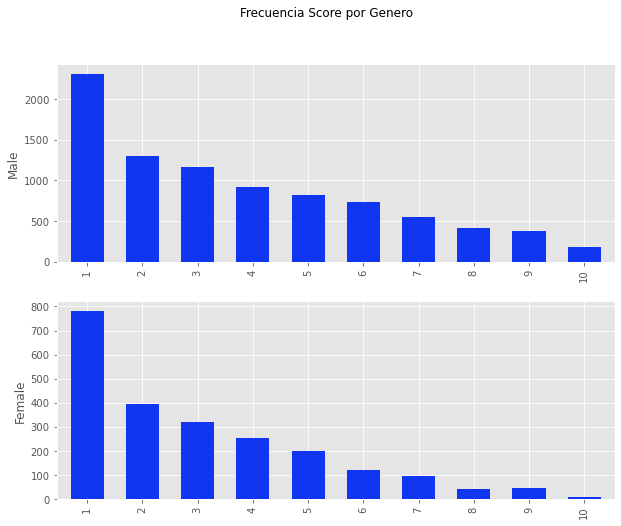

In [53]:
# GENERO  VIOLENT DECILE SCORE
# Como en el gráfico anterior la concentración de cantidad de HOMBRES respecto de MUJERES en todos los niveles es mayor, aunque el puntaje de posibles reincidentes, 
# estan más concentrados en los primeros 6 niveles y con una visible tendencia decreciente de menor a mayor posibilidad de reincidencia.

desc_column(df2, 'sex')

df_sex_vds = df2.groupby('sex')
sex_count_vds = df2.groupby('sex')['name'].count()

fig, ax = plt.subplots(2, figsize=(10, 8))

for (i, sex) in enumerate(['Male', 'Female']):
    ((df_sex_vds.get_group(sex).groupby('v_decile_score')['name'].count()).plot(kind='bar', ax=ax[i], color='#1136f2', width = 0.6))
         
    ax[i].set_ylabel(sex)
    ax[i].set_xlabel('')

fig.suptitle("Frecuencia Score por Genero")
plt.show()

4.2-  Como segundo paso graficaremos REINCIDENTES "is_recid" y REINCIDENTES VIOLENTOS analizando uno a uno las variables ETNIA y GENERO para los tres grupos con más registros

In [54]:
df_rein = df2 [[ 'sex', 'race', 'is_recid', 'is_violent_recid']].copy()

In [55]:
rein = df_rein[df_rein.is_recid==1]

In [56]:
# Reenumera las filas desde cero nuevamente
rein.reset_index(inplace=True, drop=True)

In [57]:
rein_vio = df_rein[df_rein.is_violent_recid==1]

In [58]:
# Reenumera las filas desde cero nuevamente
rein_vio.reset_index(inplace=True, drop=True)

In [59]:
# Reincidentes por grupo etnico
resid_race = rein.groupby('race')['is_recid'].count()
total_is_resid = resid_race[:].sum()

In [60]:
# Reincidente violentos por grupo etnico
resid_race_vio = rein_vio.groupby('race')['is_violent_recid'].count()
total_is_resid_vio = resid_race_vio[:].sum()

In [61]:
# Reincidente por genero
resid_sex = rein.groupby('sex')['is_recid'].count()
total_is_resid_sex = resid_sex[:].sum()

In [62]:
# Reincidente violentos por genero
resid_sex_vio = rein_vio.groupby('sex')['is_violent_recid'].count()
total_is_resid_vio_sex = resid_sex_vio[:].sum()

In [63]:
# Reincidentes por grupo etnico en porcentajes
colum_perce = resid_race[:]*100/total_is_resid
values = pd.Series([round(val, 2) for val in colum_perce])
colum_perce[0:] = values
print(colum_perce)

race
African-American    58.74
Asian                0.30
Caucasian           29.40
Hispanic             7.05
Native American      0.35
Other                4.16
Name: is_recid, dtype: float64


In [64]:
# Reincidentes violentos por grupo etnico en porcentajes
colum_perce1 = resid_race_vio[:]*100/total_is_resid_vio
values1 = pd.Series([round(val, 2) for val in colum_perce1])
colum_perce1[0:] = values1
print(colum_perce1)

race
African-American    61.34
Asian                0.45
Caucasian           26.42
Hispanic             6.58
Native American      0.68
Other                4.54
Name: is_violent_recid, dtype: float64


In [65]:
# Reincidentes por genero en porcentajes
colum_perce2 = resid_sex[:]*100/total_is_resid_sex
values2 = pd.Series([round(val, 2) for val in colum_perce2])
colum_perce2[0:] = values2
print(colum_perce2)

sex
Female    15.56
Male      84.44
Name: is_recid, dtype: float64


In [66]:
# Reincidentes violentos por genero en porcentajes
colum_perce3 = resid_sex_vio[:]*100/total_is_resid_vio_sex
values3 = pd.Series([round(val, 2) for val in colum_perce3])
colum_perce3[0:] = values3
print(colum_perce3)

sex
Female    13.27
Male      86.73
Name: is_violent_recid, dtype: float64


Los dos gráficos nos muestran claramente la prevalecencia de los Afroamericanos en numero de REINCIDENTES en comparacion con los otros grupos con 58,7% de reincidencia y 61,35 en Reincidencia con Violencia.
Los caucasicos representan el segundo grupo mayoritario con un 29,4% de Reincidentes y  26,4% Reincidentes Violentos.
En tercer lugar esta el grupo de los hispanos con un 7% de reincidencia y un 6,6% de Reincidencia con violencia.

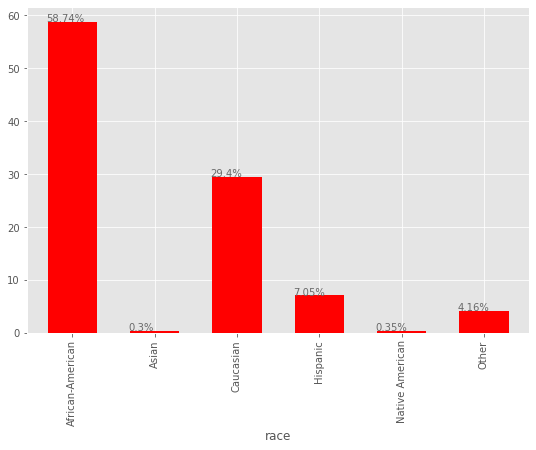

In [67]:
# Gráfico REINCIDENTES por ETNIA 
ax = colum_perce.plot(x='race', y=['is_recid'], kind="bar", figsize=(9,6), color='red', width = 0.6)
totals= []
for i in ax.patches:
    totals.append(i.get_height())
    
total = sum(totals)

for i in ax.patches:
    ax.text(i.get_x()-.02, i.get_height()+.08,\
            str(round((i.get_height()/total)*100,2))+'%', fontsize=10, color='dimgrey')

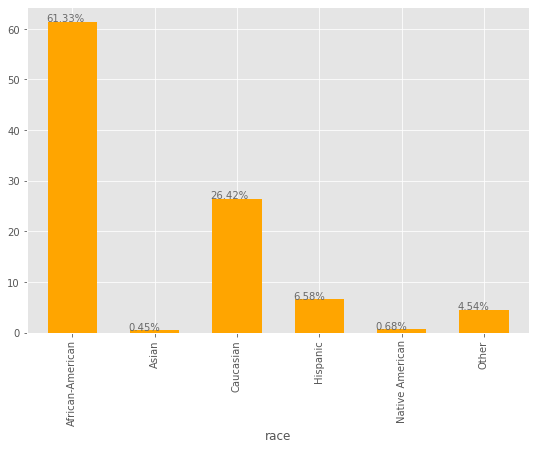

In [68]:
# Gráfico REINCIDENTES VIOLENTOS por ETNIA 
ax1 = colum_perce1.plot(x='race', y=['is_violent_recid'], kind="bar", figsize=(9,6), color='orange', width = 0.6)

totals1= []
for i in ax1.patches:
    totals1.append(i.get_height())
    
total1 = sum(totals1)

for i in ax1.patches:
    ax1.text(i.get_x()-.02, i.get_height()+.08,\
            str(round((i.get_height()/total1)*100,2))+'%', fontsize=10, color='dimgrey')

Los otros dos gráficos agrupados por Genero nos muestra una la prevalecencia mayoritaria de los hombres que para el caso de Reincidentes es del 84,4%.
Los hombres son con diferencia tambien el grupo mas grande con un 86,7% de Reincidentes con Violencia frente a las mujeres que representan un 13,3%.

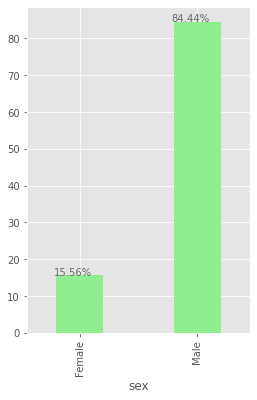

In [69]:
# Gráfico REINCIDENTES por SEXO 
ax2 = colum_perce2.plot(x='sex', y=['is_recid'], kind="bar", figsize=(4,6), color='lightgreen', width = 0.4)

totals2= []
for i in ax2.patches:
    totals2.append(i.get_height())
    
total2 = sum(totals2)

for i in ax2.patches:
    ax2.text(i.get_x()-.02, i.get_height()+.08,\
            str(round((i.get_height()/total2)*100,2))+'%', fontsize=10, color='dimgrey')

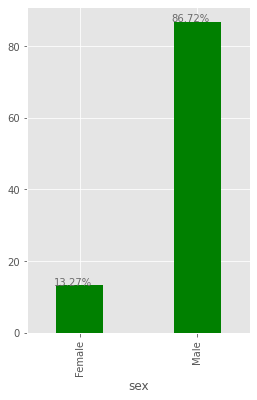

In [70]:
# Gráfico REINCIDENTES VIOLENTOS por SEXO 
ax3 = colum_perce3.plot(x='race', y=['is_violent_recid'], kind="bar", figsize=(4,6), color='green', width = 0.4)

totals3= []
for i in ax3.patches:
    totals3.append(i.get_height())
    
total3 = sum(totals3)

for i in ax3.patches:
    ax3.text(i.get_x()-.02, i.get_height()+.08,\
            str(round((i.get_height()/total1)*100,2))+'%', fontsize=10, color='dimgrey')

5- ¿Para qué tipo de riesgos, el de delitos generales o el de delitos violentos, tiene el sistema más capacidad predictiva?

In [71]:
# Basandonos en las dos features creadas y los resultados que obtenemos podriamos indicar que ambas variables tienen un poder predictivo similar aunque la primera en conjunto se acerca al "0.5".
# Al utilizar la informacion de las columnas efectivamente reincidentes "==1"  para ambas variables conseguimos un valor mas alto "0.62" por lo que podria asumir que ambas datas poseen un poder predictivo similar para las dos variables.